# Tensorflow

## What is new

  * cross validation
  * mini batches

In [1]:
%pylab inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cross_validation
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


Load data from csv files.
Image is provided as space separated values in 'Image' column.

In [2]:
def make_image(xs):
    a = np.fromstring(xs, sep=' ', dtype=np.float).reshape(96, 96)
    return a / 256.0

df = pd.read_csv('../data/training.csv', converters={'Image': make_image})
df['Image'].head()

0    [[0.9296875, 0.921875, 0.92578125, 0.9296875, ...
1    [[0.85546875, 0.83984375, 0.796875, 0.765625, ...
2    [[0.5625, 0.5546875, 0.62109375, 0.703125, 0.7...
3    [[0.75390625, 0.75, 0.75390625, 0.7578125, 0.7...
4    [[0.57421875, 0.578125, 0.625, 0.765625, 0.839...
Name: Image, dtype: object

## Select only few labels

This notebook will try to predict only nose_tip labels

In [3]:
labels = ['nose_tip_x', 'nose_tip_y']
train = df[labels + ['Image']].dropna()
print('All images: %d, with labels: %d' % (len(df), len(train)))

All images: 7049, with labels: 7049


## Show image

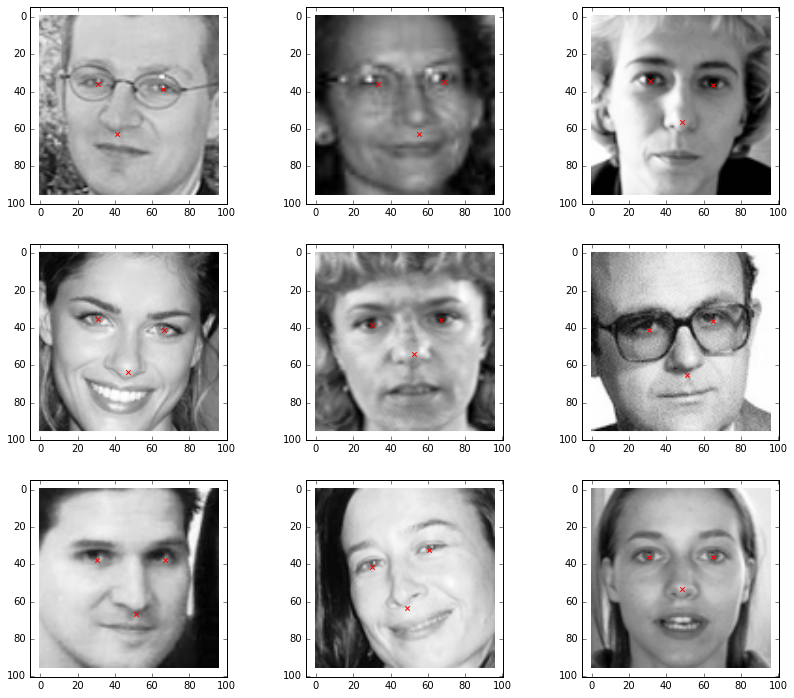

In [4]:
def show_image_with_labels(row):
    plt.imshow(row.Image, cmap='Greys_r')
    xs = [row.left_eye_center_x, row.right_eye_center_x, row.nose_tip_x]
    ys = [row.left_eye_center_y, row.right_eye_center_y, row.nose_tip_y]
    plt.scatter(x=xs, y=ys, marker='x', color='red')
    
def show_random_images(df):
    plt.gray()
    fig = plt.figure()
    n = df.shape[0]
    for i in range(9):
        fig.add_subplot(3, 3, i+1)
        index = random.randint(0, n)
        show_image_with_labels(df.iloc[index])
    plt.show()    

rcParams['figure.figsize'] = 14, 12    
show_random_images(df)

## Build tensorflow model

### Evaluate score (RMSE)

In [5]:
def rmse(expected, predicted):
    p = tf.square(expected - predicted)
    ds = tf.reduce_mean(p, 1)
    return tf.reduce_mean(ds) #tf.sqrt(tf.reduce_mean(ds))

### Prepare training data

Convert images read by pandas into ndarray

In [6]:
VECTOR_SIZE = 96*96
X = np.concatenate(train['Image'].apply(lambda x: np.reshape(x, VECTOR_SIZE)))
X = np.reshape(X, (len(train), VECTOR_SIZE))
print(X.shape)
Y = train[labels].as_matrix() / 48.0 - 1
print(Y.shape)


class Dataset:

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._num_examples = X.shape[0]

    def next_batch(self, batch_size=20):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self.X = self.X[perm]
            self.Y = self.Y[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self.X[start:end], self.Y[start:end]

    def epoch_completed(self):
        return self._epochs_completed

(7049, 9216)
(7049, 2)


### Percepton

In [10]:
L1_COUNT = 100
# Create placeholders for image data and expected point positions
x_placeholder = tf.placeholder(tf.float32, shape=[None, VECTOR_SIZE])
y_placeholder = tf.placeholder(tf.float32, shape=[None, 2])

# Build neural network
def build_model(xs):
    W1 = tf.Variable(tf.truncated_normal([VECTOR_SIZE, L1_COUNT], stddev=0.1))
    b1 = tf.Variable(tf.constant(0.1, shape=[L1_COUNT]))
    l1 = tf.nn.relu(tf.matmul(xs, W1) + b1)
    W2 = tf.Variable(tf.truncated_normal([L1_COUNT, 2], stddev=0.1))
    b2 = tf.Variable(tf.constant(0.1, shape=[2]))
    return tf.matmul(l1, W2) + b2

# Define loss function
model = build_model(x_placeholder)
loss = rmse(y_placeholder, model)

# Train model
EPOCH = 1000
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, train_size=0.8)
dataset = Dataset(X_train, Y_train)
with tf.Session() as session:
    start_time = time.time()
    session.run(tf.initialize_all_variables())
    train_step = tf.train.GradientDescentOptimizer(5e-3).minimize(loss)
    last_epoch = -1
    while dataset.epoch_completed() < EPOCH:
        (batch_x, batch_y) = dataset.next_batch(20)
        train_step.run(feed_dict={x_placeholder: batch_x, y_placeholder: batch_y})
        if dataset.epoch_completed() > last_epoch and dataset.epoch_completed() % 100 == 0:
            score = loss.eval(feed_dict={x_placeholder: X_test, y_placeholder: Y_test})
            print('Epoch: %d, Score: %f' % (dataset.epoch_completed(), score))
            last_epoch = dataset.epoch_completed()
    Y2_test = model.eval(feed_dict={x_placeholder: X_test})
    score = loss.eval(feed_dict={x_placeholder: X, y_placeholder: Y})
    print('Finished in %d seconds with score: %f' % (time.time()-start_time, score))  

Epoch: 0, Score: 457.146423
Epoch: 100, Score: 0.009649
Epoch: 200, Score: 0.008931
Epoch: 300, Score: 0.008420
Epoch: 400, Score: 0.007850
Epoch: 500, Score: 0.007591
Epoch: 600, Score: 0.007376
Epoch: 700, Score: 0.007182
Epoch: 800, Score: 0.007020
Epoch: 900, Score: 0.006947
Epoch: 1000, Score: 0.006883
Finished in 1796 seconds with score: 0.006150


Now when we have trained model, lets check where it thinks a nose is

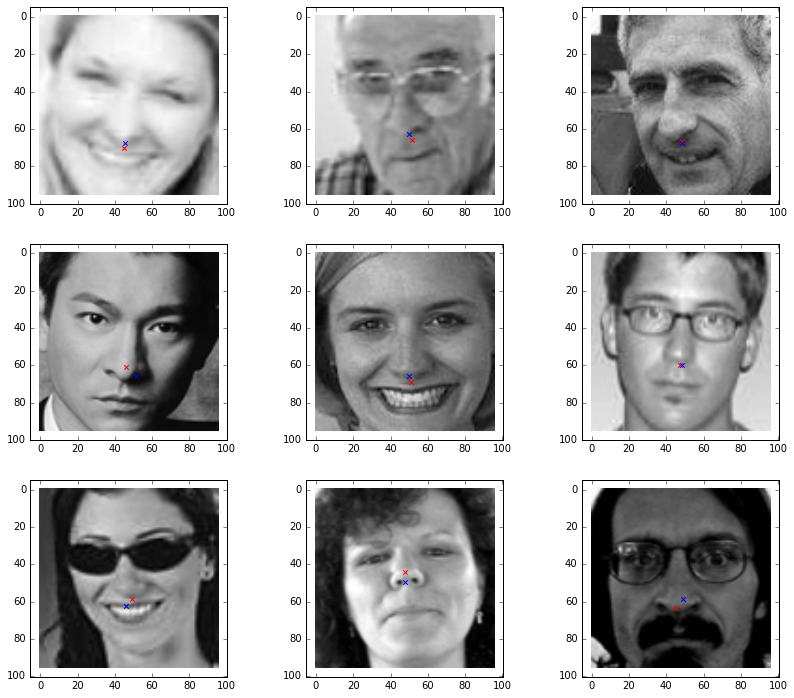

In [11]:
def show_image(image, expected, predicted):
    a = (expected + 1) * 48
    b = (predicted + 1) * 48
    plt.imshow(image)
    plt.scatter(x=a[0], y=a[1], marker='x', color='r')
    plt.scatter(x=b[0], y=b[1], marker='x', color='b')
    
def plot_random_images(images, expected, predicted):
    rcParams['figure.figsize'] = 14, 12
    plt.gray()
    fig = plt.figure()
    n = images.shape[0]
    for i in range(9):
        fig.add_subplot(3, 3, i+1)
        index = random.randint(0, n)
        image = np.reshape(images[index], (96, 96))
        show_image(image, expected[index], predicted[index])
    plt.show()    
    
    
plot_random_images(X_test, Y_test, Y2_test)  

## Remarks

  * Smaller batches reguire smaller learning rate
  * Mini batches helped with stuck at average